In [188]:
import os
os.chdir('/Users/ngdnhtien/Codespace/bqec@huikhoon')

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import math
import utility as ut 
from scipy.optimize import minimize

%config InlineBackend.figure_formats = ['svg']

In [189]:
def compare_2d_arrays(arr1, arr2):

    if len(arr1) != len(arr2) or any(len(row1) != len(row2) for row1, row2 in zip(arr1, arr2)):
        print("Not having the same dimension")
        return
    flag = False
    
    for i in range(len(arr1)):
        for j in range(len(arr1[i])):
            if arr1[i][j] != arr2[i][j]:
                flag = True
                print(f"Mismatch found at ({i}, {j}): {arr1[i][j]} != {arr2[i][j]}")
    
    if not flag:
        print("All matches.")
    else:
        print("Flagged")

# The pulse

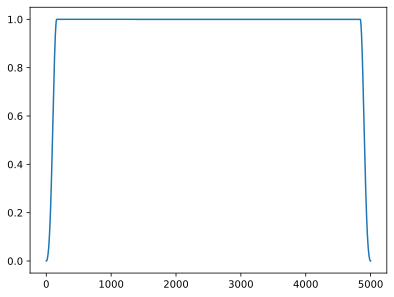

In [190]:
T = 5000 #ns
times = np.linspace(0,T,T+1)

def ftb(t):
    t_start = times[0]
    t_stop = times[-1]
    t_rise = 160
    t_fall = 160
    def blackman(t, t_start, t_stop, a=0.16):
        def box(t, t_start, t_stop):
            if t < t_start:
                return 0.0
            if t > t_stop:
                return 0.0
            return 1.0
        T = t_stop - t_start
        box_vec = np.vectorize(box)
        return (0.5* box_vec(t, t_start, t_stop)* (1.0 - a - np.cos(2.0 * np.pi * (t - t_start) / T) + a * np.cos(4.0 * np.pi * (t - t_start) / T)))
    if t_start <= t <= t_stop:
        f = 1.0
        if t <= t_start + t_rise:
            f = blackman(t, t_start, t_start + 2 * t_rise)
        elif t >= t_stop - t_fall:
            f = blackman(t, t_stop - 2 * t_fall, t_stop)
        return f
    else:
        return 0.0

plt.plot(times,[ftb(t) for t in times])

In [191]:
def dressed_coherent(alpha):
    """
        Construct a coherent state
    """

    state = 0
    for n in range(dimCavity):
        state += (alpha**n)*ordered_labelled_coupled_states[n]/np.sqrt(float(math.factorial(n)))
    state = np.exp(-np.abs(alpha)**2/2)*state
    
    return state.unit()

# Convergence test

In [192]:
dim = {
    'a': [10, 20, 30, 40, 50, 60],
    'c': [10, 20, 30, 40, 50, 60] # add intermediate steps
}

ratio = {
    '1': [-10, -5, 5, 10],
    '2': 0.064,
    '3': [-1, 0.5, -0.5, 0.2, 0.2, 0.5, 1],
    '4': [0, 0.25, 0.5, 0.75, 1] # add intermediate values: DONE
}

In [193]:
def compute_alpha(r1):
    return 1/np.abs(r1)

def staticHamiltonian(a_op, c_op, omega_a, omega_c, alpha, g_ac):
    """ 
        Construct the Hamiltonian for the given set of parameters
        The `a_op` and `c_op` are the annihilation of the respective mode `a` and `c` 
        Because it is dimension-dependent, they are taken as inputs of the Hamiltonian.
        The rest are parameters.
    """

    EC = alpha
    EJ = omega_c**2/(8*alpha)

    n_op = -1j * (8*EC/EJ)**(-1/4) * (c_op-c_op.dag())/np.sqrt(2)
    phi_op = (8*EC/EJ)**(1/4) * (c_op+c_op.dag())/np.sqrt(2)

    H_cav = omega_a * a_op.dag() * a_op
    H_anc = 4 * EC * n_op**2 - EJ * phi_op.cosm()
    H_int = 1j * np.abs(np.real(g_ac)) * (c_op - c_op.dag()) * (a_op + a_op.dag()) # plus i: DONE
    H_static = H_cav + H_anc + H_int

    return H_cav, H_anc, H_int, H_static

In [268]:
options = qt.Options()
options.nsteps = 20_000

# The loop

In [278]:
r1 = -10
r2 = 0.064
r3 = -1
r4 = 0.01

omega_c = (5.715)
alpha = 0.17

omega_10 = omega_c - alpha
delta_ac = r1 * alpha 
g_ac = r2 * delta_ac 
delta_dc = r3 * alpha
Omega_d = np.sqrt(r4) * np.abs(delta_dc)

omega_a = omega_10 + delta_ac
omega_d = omega_10 + delta_dc

print('r1, r2, r3, r4 = ', r1, r2, r3, r4)
print('delta_ac, delta_dc, Omega_d, g_ac = ', delta_ac, delta_dc, Omega_d, g_ac)

dimTransmon = 15
dimCavity = 20
print(dimTransmon, dimCavity)
# Initialize annihilation operators
a_op = qt.tensor(qt.qeye(dimTransmon), qt.destroy(dimCavity))
c_op = qt.tensor(qt.destroy(dimTransmon), qt.qeye(dimCavity))
# Initilize Hamiltonian
H_cav, H_anc, H_int, H_static = staticHamiltonian(a_op, c_op, omega_a, omega_c, alpha, g_ac)

r1, r2, r3, r4 =  -10 0.064 -1 0.01
delta_ac, delta_dc, Omega_d, g_ac =  -1.7000000000000002 -0.17 0.017 -0.10880000000000001
15 20


In [279]:
H_uncoupled = H_cav + H_anc

basis_state = []

for NC in range(dimTransmon):
    for NA in range(dimCavity):
        basis_state.append([qt.tensor(qt.basis(dimTransmon, NC), qt.basis(dimCavity, NA)), [NC, NA]])

uncoupled_eig_energies, uncoupled_eig_states = H_uncoupled.eigenstates()

labelled_prod_states = []

for eig_state in uncoupled_eig_states:
    max_fidelity = 0
    for state in basis_state:
        fidelity = qt.fidelity(state[0], eig_state)
        if fidelity > max_fidelity:
            max_fidelity = fidelity 
            label_eig_state = state[1]
    labelled_prod_states.append([eig_state, label_eig_state])

H_coupled = H_uncoupled + H_int
coupled_eig_energies, coupled_eig_states = H_coupled.eigenstates()

labelled_coupled_states = []

for eig_state in coupled_eig_states:
    max_fidelity = 0
    for state in labelled_prod_states:
        fidelity = qt.fidelity(state[0], eig_state)
        if fidelity > max_fidelity:
            max_fidelity = fidelity 
            label_eig_state = state[1]
    labelled_coupled_states.append([eig_state, label_eig_state])

In [280]:
ordered_labelled_coupled_states = []
for NA in range(dimCavity):
    for state in labelled_coupled_states:
        if state[1][0] == 0 and state[1][1] == NA:
            ordered_labelled_coupled_states.append(state[0])

In [314]:
NA_op = 0

for NA in range(dimCavity):
    NA_op += NA * ordered_labelled_coupled_states[NA] * ordered_labelled_coupled_states[NA].dag()

In [281]:
psi0_dressed = dressed_coherent(1.5)

# Time-dependent simulation

In [282]:
def H_eff(t, args):
    """ 
        Time-dependent driving Hamiltonian parameters
    """

    return -Omega_d*ftb(t)*np.exp(-1j*2*np.pi*omega_d*t)+np.conj(Omega_d)*ftb(t)*np.exp(1j*omega_d*2*np.pi*t) # There's a minus sign: Done

H_full = [H_static*(2*np.pi), [(2*np.pi)*(c_op - c_op.dag()), H_eff]]

T = 5000
times = np.linspace(0,T,T+1)

res = qt.mesolve(H_full, psi0_dressed, times, progress_bar=True, options=options)

10.0%. Run time:  78.77s. Est. time left: 00:00:11:47
20.0%. Run time: 128.15s. Est. time left: 00:00:08:32
30.0%. Run time: 176.48s. Est. time left: 00:00:06:51
40.0%. Run time: 225.30s. Est. time left: 00:00:05:37
50.0%. Run time: 272.03s. Est. time left: 00:00:04:31
60.0%. Run time: 318.15s. Est. time left: 00:00:03:32
70.0%. Run time: 364.61s. Est. time left: 00:00:02:36
80.0%. Run time: 411.28s. Est. time left: 00:00:01:42
90.0%. Run time: 459.75s. Est. time left: 00:00:00:51
Total run time: 523.32s


In [301]:
time_dependent_res = qt.qsave(res, './ode_convergence/data/time_dependent_res')

# Fit Kerr

In [403]:
def H_eff(c0, c1, c2, c3):
    return ((2*np.pi)*omega_a+c0)*NA_op + c1 * NA_op**2 + c2 * NA_op**3 + c3 * NA_op**4

In [404]:
def objective(args):

    c0, c1, c2, c3 = args 

    evol_state = ((-1j*H_eff(c0, c1, c2, c3)*times[-1]).expm() * psi0_dressed).unit()
    infd = np.abs(1 - qt.fidelity(evol_state, res.states[-1]))
    print(infd)
    return infd

In [405]:
infd = objective([1e-4, 1e-6, 1e-7, 1e-8])

infd

0.011928631655451105


0.011928631655451105

In [395]:
1-0.20679919392158685

0.7932008060784131

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

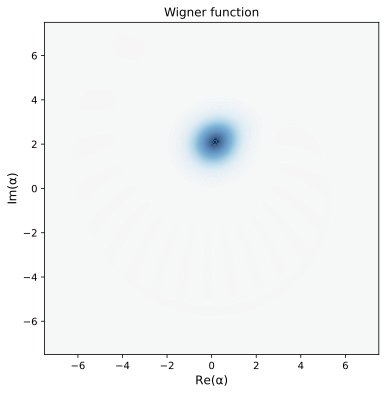

In [346]:
qt.plot_wigner(evol_state.ptrace(1))

In [406]:
from scipy.optimize import minimize

x0 = [1e-4, 1e-6, 1e-7, 1e-8]
solution = minimize(objective, x0, method='Nelder-Mead', tol=1e-7)

solution

0.011928631655451105
0.015585940540605248
0.012184144614210246
0.012098600475513144
0.012038600119036902
0.009756242435293272
0.008690345200499716
0.009630424177534125
0.008939713412452366
0.008510502253362362
0.009209416438817342
0.009285326362494573
0.009511603454227635
0.00877677705291291
0.009725327928388094
0.008688485807506918
0.009399540767415449
0.008608430897428243
0.008899200732314094
0.008597116213694966
0.0086409886978831
0.008519306236888458
0.008887157137312807
0.008523770448592649
0.008581496974319314
0.008432997493791228
0.008416102337303832
0.00867505171447891
0.008483773823692364
0.008534740974103894
0.008476252608311419
0.008449168825689135
0.008365418041302974
0.00830577950545175
0.008311233577633526
0.008218157971074058
0.008095945580108954
0.008164728408360244
0.008032085753063245
0.0079208365270943
0.007864800558722518
0.0076664690296212035
0.007569450133632416
0.007262103629548489
0.00740351796681038
0.007044853440104637
0.0066935607419117416
0.00644060368972321

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.50898404905842e-05
             x: [ 1.239e-04 -2.281e-06 -7.413e-07  5.072e-08]
           nit: 126
          nfev: 219
 final_simplex: (array([[ 1.239e-04, -2.281e-06, -7.413e-07,  5.072e-08],
                       [ 1.239e-04, -2.260e-06, -7.469e-07,  5.132e-08],
                       ...,
                       [ 1.240e-04, -2.238e-06, -7.599e-07,  5.251e-08],
                       [ 1.239e-04, -2.221e-06, -7.684e-07,  5.332e-08]]), array([ 6.509e-05,  6.510e-05,  6.511e-05,  6.512e-05,
                        6.513e-05]))

In [374]:
qt.fidelity(evol_state, res.states[-1])

0.7563080477738666

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

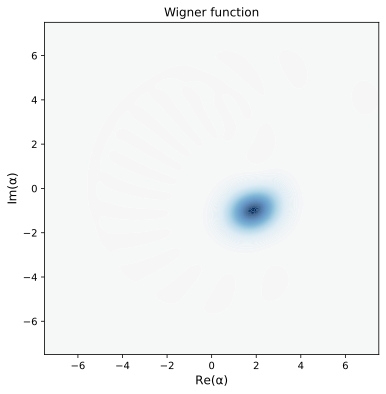

In [408]:
evol_state = ((-1j*H_eff(solution.x[0], solution.x[1], solution.x[2], solution.x[3])*times[-1]).expm() * psi0_dressed).unit()

qt.plot_wigner(evol_state.ptrace(1))